In [121]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
from nltk.tokenize import word_tokenize

In [123]:
import tensorflow as tf

In [124]:
tf.test.is_built_with_cuda()

True

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import TfidfVectorizer

#### Eval method
Submissions are scored using MCRMSE, mean columnwise root mean squared error.

In [126]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
SAMPLE_SUBMISSION = 'data/sample_submission.csv'
RANDOM_STATE = 25

In [127]:
FEATURE_COLUMNS = ['full_text']
TARGET_COLUMNS = ['cohesion', 'syntax','vocabulary', 'phraseology', 'grammar','conventions']

In [128]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [129]:
# Chollet transformer heuristic
# S = number of samples / mean number of words per sample
# if S > 1500 --> Sequence model
# else --> bag-of-bigrams

tokenized_sentences = train.full_text.map(word_tokenize)
mean_number_of_tokens = tokenized_sentences.map(len).mean().round()
S = train.shape[0] / mean_number_of_tokens
S

8.321276595744681

In [130]:
train.shape

(3911, 8)

In [131]:
test.shape

(3, 2)

In [132]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [203]:
X, Y = train[FEATURE_COLUMNS], train[TARGET_COLUMNS]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=.25)

X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

((3128, 1), (587, 1), (196, 1), (3128, 6), (587, 6), (196, 6))

In [204]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

In [205]:
max_tokens = 25_000
max_length = 1000

In [206]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = 'int',
    output_sequence_length = max_length
)

In [207]:
vectorizer.adapt(X_train)

In [208]:
vectorized_train = vectorizer(X_train)
vectorized_valid = vectorizer(X_valid)
vectorized_test = vectorizer(X_test)

In [209]:
vectorized_train.shape, vectorized_test.shape

(TensorShape([3128, 1000]), TensorShape([196, 1000]))

In [292]:
# inputs: A 3D tensor, with shape [batch, timesteps, feature].
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (None, )),
    tf.keras.layers.Embedding(input_dim = max_tokens, output_dim = 256),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 64)),
    
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(6)
])

In [293]:
model.compile(loss = 'mse', metrics = 'mean_absolute_percentage_error', optimizer = tf.keras.optimizers.Adam(lr = 1e-3))

/home/hdd_n/mambaforge/envs/tf_env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [294]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 256)         6400000   
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 6)                 774       
                                                                 
Total params: 6,524,422
Trainable params: 6,524,422
Non-trainable params: 0
_________________________________________________________________


In [295]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_scratch.keras", save_best_only=True), 
    # tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     patience = 10)
]

In [296]:
history = model.fit(
    x = vectorized_train, 
    y = Y_train, 
    validation_data = (vectorized_valid, Y_valid),
    callbacks = callbacks,
    epochs = 20)

Epoch 1/20
98/98 [==============================] - 6s 55ms/step - loss: 2.1088 - mean_absolute_percentage_error: 36.6918 - val_loss: 0.5024 - val_mean_absolute_percentage_error: 17.9344
Epoch 2/20
98/98 [==============================] - 5s 53ms/step - loss: 0.6426 - mean_absolute_percentage_error: 21.6825 - val_loss: 0.4332 - val_mean_absolute_percentage_error: 17.3861
Epoch 3/20
98/98 [==============================] - 5s 51ms/step - loss: 0.5177 - mean_absolute_percentage_error: 19.5143 - val_loss: 0.4078 - val_mean_absolute_percentage_error: 17.4480
Epoch 4/20
98/98 [==============================] - 5s 52ms/step - loss: 0.4601 - mean_absolute_percentage_error: 18.3353 - val_loss: 0.4202 - val_mean_absolute_percentage_error: 18.8851
Epoch 5/20
98/98 [==============================] - 5s 52ms/step - loss: 0.4139 - mean_absolute_percentage_error: 17.3259 - val_loss: 0.3934 - val_mean_absolute_percentage_error: 16.9722
Epoch 6/20
98/98 [==============================] - 5s 53ms/step 

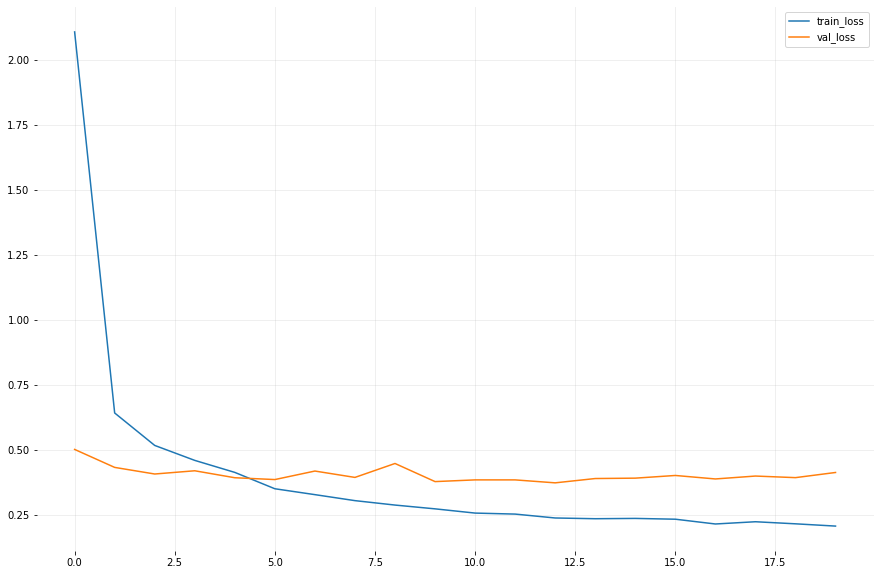

In [297]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.box(False)
plt.grid(True, alpha = .25)
plt.legend()
plt.show()

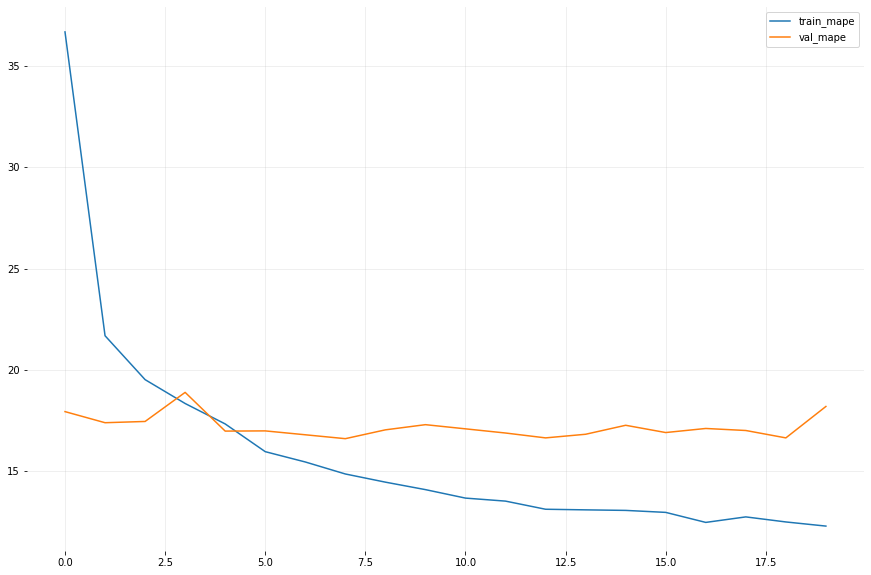

In [298]:
plt.figure(figsize=(15,10))
plt.plot(history.history['mean_absolute_percentage_error'], label = 'train_mape')
plt.plot(history.history['val_mean_absolute_percentage_error'], label = 'val_mape')
plt.box(False)
plt.grid(True, alpha = .25)
plt.legend()
plt.show()

In [289]:
eval = model.evaluate(vectorized_test, Y_test)
eval

7/7 [==============================] - 0s 22ms/step - loss: 0.4311 - mean_absolute_percentage_error: 17.7972


[0.43114906549453735, 17.79724884033203]

In [263]:
y_pred = model.predict(vectorized_test)

7/7 [==============================] - 0s 19ms/step


In [272]:
y_true.shape, y_pred.shape

(TensorShape([196, 6]), (196, 6))

In [299]:
def mcrmse(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

In [300]:
mcrmse(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.6928085952557228>